# Data rate prediction notebook

The question we're trying to answer: how well can an AP predict the data rate a client will experience when it connects to it, using historical data?

## Data set

AP info:

| ap | 802.11 type | lat | lon | channel | cntr. freq (MHz) | bw (MHz) |
|-------|-------------|-----------|-----------|---------|------------------|----------|
| ap-n | n | 41.111879 | -8.631146 | 6 | 2437 | 20 |
| ap-ac | ac (wave 1) | 41.111879 | -8.631146 | 40 | 5200 | 40 |
| ap-ad | ad | 41.111879 | -8.631146 | 1 | 60480 | 2160 |


### Column explanation

Some fields have been added `[NEW]` or updated `[UPDATED]` when compared with previous version.

* **systime** : system time (1 Hz resolution) that this row refers to. All node clocks were synchronized through NTP.
* **traceNr** `[NEW]` : nr. of the trace the row belongs to. 
* **lon** `[NEW]` : longitude (in degrees) reported by the receiver's GPS at `systime`
* **lat** `[NEW]` : latitude reported by the receiver's GPS at `systime`
* **receiverAlt** : altitude (in meters) reported by the receiver's GPS at `systime`
* **receiverX** : x coordinate of the receiver's position when space is discretized as a Cartesian plane and the sender is set to be the origin of the coordinate system. The x axis corresponds to east-west (positive values are east, negative values are west). Unit is meters.
* **receiverY** : y coordinate of the receiver's position when space is discretized as a Cartesian plane
* **receiverDist** : distance (in meters) of receiver to ap(s)
* **receiverSpeed** : speed (in m/s) reported by the receiver's GPS at `systime`
* **receiverId** : system-specific id for the client (in the vehicle)
* **senderId** : system-specific id for the ap serving the client (side of the road)
* **isIperfOn** : 1 if row's `systime` corresponds to a period where iperf is known to have been running on the receiver side. **In this clase, our `gluten` app was always on, so this column is meaningless.**
* **isInLap** : 1 if this row's systime has been marked as being part of a time period where clients were doing laps around the APs, 0 otherwise. **This needs improvement.**
* **rssiMean** `[UPDATED]` : the mean of the RSSI (Received Signal Strength Indicator) values of frames received by the client from the ap during the 1-second period systime period the row refers to. **For 802.11ad, we retrieve RSSI from sector sweep feedback frames.**
* **channelFreq** : center frequency of the WiFi channel used, in MHz.
* **channelBw** : bandwidth of the WiFi channel used, in MHz.
* **channelUtil** `[UPDATED]` : percentage of time the wireless medium was sensed to be busy during the 1-second period systime period the row refers to. **In traces 40x, the 802.11n and ac routers didn't log channel busy time, and as such we had to approximate channel util. based on x,y coordinates and nr. of active clients.**
* **wifiType** `[NEW]` : 802.11 type (e.g., n, ac or ad).
* **nrClients** `[NEW]` : nr. of parallel clients operating in `wifiType` mode, on the same channel and bandwidth as `receiverId`.
* **dataRateMedian** `[NEW]` : the median of the bitrate values of frames received by the client from the ap during the 1-second period systime period the row refers to.
* **dataRateMean** : the mean of the bitrate values of frames received by the client from the ap during the 1-second period systime period the row refers to.
* **nBytesReceived** : total number of bytes received by the client from the ap during the 1-second period systime period the row refers to.
* **tghptConsumer** `[NEW]` : throughput reported by the receiving end of the `gluten` app, during the 1-second period systime period the row refers to.

### Dataset loading 


In [150]:
import warnings
import pandas
import sys
import numpy as np

warnings.filterwarnings('ignore')

base_filename = "/Volumes/data/vehicular-traces-gaia/final-exp-log.csv"
dataset = pandas.read_csv(base_filename)
dataset = dataset.loc[dataset['isIperfOn'] == 1] # filter out periods when iperf was off
dataset = dataset.reset_index(drop = True)

## Feature correlation analysis
### Code

In [153]:
# let us print out a correlation matrix (weirdly, can't farm this out to a method
# because then it won't show in the notebook)
# prepare a data set for correlation analysis
corDs = dataset.copy()
# drop unneeded columns
corDs.drop(['systime', 'isInLap', 'senderId', 'receiverId', 'isIperfOn', 'traceNr', 'wifiType'], axis = 1, inplace = True)
#corDs # uncomment if you want to print it out

In [154]:
# show correlation matrix for pearson (measures linear relationship between normally-distributed variables)
corMat = corDs.corr(method = 'pearson') 
corMat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,lon,lat,receiverAlt,receiverX,receiverY,receiverDist,receiverSpeed,rssiMean,channelFreq,channelBw,channelUtil,dataRateMedian,dataRateMean,nBytesReceived,tghptConsumer,nrClients
lon,1,0.096,0.62,-1,0.096,-0.37,-0.19,0.15,0.013,0.0062,0.058,0.083,0.089,0.085,0.1,0.028
lat,0.096,1,0.26,-0.096,1,0.15,-0.058,-0.042,-0.05,-0.055,0.11,-0.018,-0.02,-0.023,-0.024,-0.0072
receiverAlt,0.62,0.26,1,-0.62,0.26,-0.094,-0.045,-0.06,-0.068,-0.075,0.098,-0.025,-0.027,0.00091,0.015,-0.13
receiverX,-1,-0.096,-0.62,1,-0.096,0.37,0.19,-0.15,-0.013,-0.0062,-0.058,-0.083,-0.089,-0.085,-0.1,-0.028
receiverY,0.096,1,0.26,-0.096,1,0.15,-0.058,-0.042,-0.05,-0.055,0.11,-0.018,-0.02,-0.023,-0.024,-0.0072
receiverDist,-0.37,0.15,-0.094,0.37,0.15,1,0.32,-0.64,-0.27,-0.26,0.22,-0.35,-0.38,-0.41,-0.44,-0.056
receiverSpeed,-0.19,-0.058,-0.045,0.19,-0.058,0.32,1,-0.46,-0.27,-0.27,0.26,-0.28,-0.3,-0.36,-0.37,-0.076
rssiMean,0.15,-0.042,-0.06,-0.15,-0.042,-0.64,-0.46,1,0.83,0.84,-0.76,0.67,0.74,0.58,0.65,-0.022
channelFreq,0.013,-0.05,-0.068,-0.013,-0.05,-0.27,-0.27,0.83,1,1,-0.93,0.73,0.8,0.54,0.64,-0.056
channelBw,0.0062,-0.055,-0.075,-0.0062,-0.055,-0.26,-0.27,0.84,1,1,-0.93,0.71,0.78,0.52,0.61,-0.051


In [49]:
corMat = corDs.corr(method = 'kendall') # non-parametric, rank based (sees how increasing rank of one variable changes rank of another)
                                        # spearman is alternative, gives higher values but is more error prone
corMat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,lon,lat,receiverAlt,receiverX,receiverY,receiverDist,receiverSpeed,rssiMean,channelFreq,channelBw,channelUtil,dataRateMedian,dataRateMean,nBytesReceived,tghptConsumer,nrClients
lon,1,0.11,0.35,-1,0.11,-0.048,-0.067,0.024,0.0052,0.0052,0.022,0.063,0.058,0.046,0.064,0.042
lat,0.11,1,0.31,-0.11,1,0.12,-0.038,-0.032,0.02,0.02,0.15,0.1,0.097,0.09,0.091,0.015
receiverAlt,0.35,0.31,1,-0.35,0.31,0.082,0.011,-0.074,0.0036,0.0036,0.04,0.007,0.005,0.025,0.037,-0.1
receiverX,-1,-0.11,-0.35,1,-0.11,0.048,0.067,-0.024,-0.0052,-0.0052,-0.022,-0.063,-0.058,-0.046,-0.064,-0.042
receiverY,0.11,1,0.31,-0.11,1,0.12,-0.038,-0.032,0.02,0.02,0.15,0.1,0.097,0.09,0.091,0.015
receiverDist,-0.048,0.12,0.082,0.048,0.12,1,0.34,-0.69,-0.2,-0.2,0.17,-0.42,-0.42,-0.39,-0.4,-0.01
receiverSpeed,-0.067,-0.038,0.011,0.067,-0.038,0.34,1,-0.4,-0.16,-0.16,0.19,-0.27,-0.28,-0.29,-0.28,-0.073
rssiMean,0.024,-0.032,-0.074,-0.024,-0.032,-0.69,-0.4,1,0.16,0.16,-0.15,0.45,0.46,0.41,0.41,0.019
channelFreq,0.0052,0.02,0.0036,-0.0052,0.02,-0.2,-0.16,0.16,1,1,-0.42,0.68,0.67,0.49,0.49,-0.069
channelBw,0.0052,0.02,0.0036,-0.0052,0.02,-0.2,-0.16,0.16,1,1,-0.42,0.68,0.67,0.49,0.49,-0.069


In [50]:
corMat = corDs.corr(method = 'spearman') # non-parametric, rank based (sees how increasing rank of one variable changes rank of another)
                                         # compared to kendall, gives higher values but is more error prone
corMat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,lon,lat,receiverAlt,receiverX,receiverY,receiverDist,receiverSpeed,rssiMean,channelFreq,channelBw,channelUtil,dataRateMedian,dataRateMean,nBytesReceived,tghptConsumer,nrClients
lon,1,0.12,0.5,-1,0.12,-0.12,-0.11,0.083,0.0082,0.0082,0.041,0.084,0.084,0.057,0.089,0.052
lat,0.12,1,0.42,-0.12,1,0.13,-0.086,0.055,0.027,0.027,0.22,0.18,0.17,0.15,0.17,0.019
receiverAlt,0.5,0.42,1,-0.5,0.42,0.11,0.013,-0.1,0.0058,0.0058,0.061,0.013,0.011,0.041,0.057,-0.13
receiverX,-1,-0.12,-0.5,1,-0.12,0.12,0.11,-0.083,-0.0082,-0.0082,-0.041,-0.084,-0.084,-0.057,-0.089,-0.052
receiverY,0.12,1,0.42,-0.12,1,0.13,-0.086,0.055,0.027,0.027,0.22,0.18,0.17,0.15,0.17,0.019
receiverDist,-0.12,0.13,0.11,0.12,0.13,1,0.52,-0.88,-0.26,-0.26,0.26,-0.58,-0.59,-0.56,-0.56,-0.015
receiverSpeed,-0.11,-0.086,0.013,0.11,-0.086,0.52,1,-0.57,-0.19,-0.19,0.28,-0.39,-0.41,-0.42,-0.4,-0.087
rssiMean,0.083,0.055,-0.1,-0.083,0.055,-0.88,-0.57,1,0.2,0.2,-0.22,0.59,0.6,0.56,0.55,0.024
channelFreq,0.0082,0.027,0.0058,-0.0082,0.027,-0.26,-0.19,0.2,1,1,-0.51,0.8,0.81,0.6,0.58,-0.073
channelBw,0.0082,0.027,0.0058,-0.0082,0.027,-0.26,-0.19,0.2,1,1,-0.51,0.8,0.81,0.6,0.58,-0.073


In [51]:
del corDs, corMat # get rid of stuff we don't need anymore

### Results discussion
* RSSI is reasonably correlated with throughput.
* Distance is reasonably negatively-correlated with throughput, as expected.
* RSSI and distance correlate pretty well with one another.
* `[NEW]` Channel frequency is strongly correlated with data rate and throughput, which makes sense : the increase of freq. bands follows the sequence 802.11n, 802.11ac, 802.11ad. There's also a correlation between frequency and bandwidth, given the design of our experiment.
* `[NEW]` Channel utilization : there's a positive correlation with the nr. of parallel clients (makes sense), and negative correlation with throghput and channel bandwidth. **Isn't it weird to find a positive correlation with receiver distance from the AP?** When the receiver distance increases, the utilization should drop in all cases.
* Data rate is pretty much a dead ringer for throughput. I'm thinking we should actually focus on predicting data rate rather than throughput. Data rate should be easier to predict as it's independent from the amount of data the client has to send.

## Data rate prediction as a classification problem
I.e. predict data rate as discrete variable.
We discretize data rate as a 4-class variable, with each class representing a different quartile.

Notes regarding classification report:
* **Precision**: TP / (TP + FP), or what percentage of predicted positives are true positives.
* **Recall**: TP / (TP + FN), or what percentage of actual positives were predicted to be positive.
* **F1-score**: can be interpreted as a weighted harmonic mean of precision and recall, (best score is 1, worst is 0).
* **Support**: number of ground truth entries in the corresponding.

### Code

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy

def printSeparator():
  print('----------------------------------------------------------------\n')

def evalClfPerf(clfName, yTest, yPred):
  print("Accuracy of", clfName, ":", accuracy_score(yTest, yPred))
  print(classification_report(yTest, yPred))

  # display a confusion matrix
  print("Confusion matrix:")
  cmat = confusion_matrix(yTest, yPred)
  plt.figure(figsize=(6.5, 6.5)) # new figure
  sn.set(font_scale=1.4) #for label size
  sn.heatmap(cmat, annot=True, annot_kws={"size": 13}, fmt='g') # font size
  plt.show()

def plotRfFeatImp(x, featNameList, clfRf):
  """
    Plot feature importance over feature data frame x for a random forest classifier clfRf.
  """
  std = numpy.std([tree.feature_importances_ for tree in clfRf.estimators_], axis=0)
  indices = numpy.argsort(clfRf.feature_importances_)[::-1]

  print("Feature importance:")
  plt.figure()
  ax = plt.bar(range(x.shape[1]), clfRf.feature_importances_[indices], yerr=std[indices], \
          align="center", color="r")
  plt.xticks(range(x.shape[1]), [featNameList[i] for i in indices], rotation = 90)
  plt.xlim([-1, x.shape[1]])
  plt.ylim([0, 0.5])
  plt.show()

def runClassifier(clf, clfName, xTrain, yTrain, xTest, yTest):
  """
    Run single classifier, passed in as argument clf.
  """

  clf.fit(xTrain, yTrain)
  yPred = clf.predict(xTest) # predict on the unseen data
  evalClfPerf(clfName, yTest, yPred)
  printSeparator()

def runClassifiersInner(df, targetName, scaler = None, nquantiles = 4):
  """
    Run multiple classifiers for the data frame passed in as argument df.
  """

  # discretize target

  # start by printing some information about the bins
  uniBins = pandas.qcut(df[targetName], q = nquantiles).unique()
  uniBins = uniBins.ravel()
  uniBins.sort()
  print("Discretizing", targetName, "into", nquantiles, "quantiles, yielding bins:\n", uniBins)

  df[targetName] = pandas.qcut(df[targetName], q=nquantiles, labels=False) # actually discretize stuff

  #  split dataset into training and test
  x = df.drop(targetName, axis=1) # x contains all the features
  y = df[targetName] # y contains only the label
  featNameList = list(x.columns)

  # scaling, see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  if scaler:
    x = scaler.fit_transform(x)

  # xTrain contains features for training, xTest contains features for testing
  # test_size = 0.3 means 30% data for testing
  # random_state = 1, is the seed value used by the random number generator
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=1)
  printSeparator()
    
  # train and test models

  # logistic regression
  clfLogr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, random_state=1)
  runClassifier(clfLogr, "logistic regression", xTrain, yTrain, xTest, yTest)
    
  # svm
  clfSvm = svm.SVC(gamma='scale', random_state=1)
  runClassifier(clfSvm, "support vector machine", xTrain, yTrain, xTest, yTest)
    
  # knn
  clfKnn = KNeighborsClassifier()
  runClassifier(clfKnn, "k-Nearest Neighbors", xTrain, yTrain, xTest, yTest)

  # decision tree    
  clfDt = DecisionTreeClassifier(random_state=1)
  runClassifier(clfDt, "decision tree", xTrain, yTrain, xTest, yTest)

  # random forest
  clfRf = RandomForestClassifier(n_estimators=100, random_state=1)
  runClassifier(clfRf, "random forest", xTrain, yTrain, xTest, yTest)
  plotRfFeatImp(x, featNameList, clfRf)
    
  # neural network (Multi Layer Perceptron w/ backpropagation)
  clfMlp = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
  runClassifier(clfMlp, "neural network - Multi-Layer Perceptron (MLP)", xTrain, yTrain, xTest, yTest)

### Classification on original features
#### Code

In [155]:
def runClassifiersOuterOg(df, featuresToDrop): 

  clDf = df.copy() # work on copy to preserve original

  # we don't care for some columns no more
  clDf.drop(featuresToDrop, axis=1, inplace=True)
  
  #  split dataset into training and test
  x = clDf.drop("dataRateMean", axis = 1) # x contains all the features
  y = clDf["dataRateMean"] # y contains only the label

  from sklearn.preprocessing import MinMaxScaler
  mms = MinMaxScaler() # subtract minimum and divide by range
  runClassifiersInner(df=clDf, targetName="dataRateMean", scaler=mms, nquantiles=4)

#### Classification with client location data
Requires some communication from client to AP.

Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(6.499, 52.316, closed='right')
 Interval(52.316, 72.02, closed='right')
 Interval(72.02, 303.115, closed='right')
 Interval(303.115, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.7961911521173409
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2090
           1       0.77      0.87      0.82      2144
           2       0.76      0.58      0.65      2122
           3       0.80      0.85      0.82      2098

    accuracy                           0.80      8454
   macro avg       0.79      0.80      0.79      8454
weighted avg       0.79      0.80      0.79      8454

Confusion matrix:


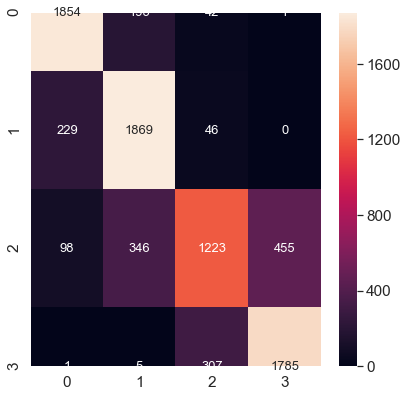

----------------------------------------------------------------

Accuracy of support vector machine : 0.8241069316299976
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2090
           1       0.79      0.87      0.83      2144
           2       0.84      0.59      0.69      2122
           3       0.80      0.94      0.87      2098

    accuracy                           0.82      8454
   macro avg       0.83      0.82      0.82      8454
weighted avg       0.83      0.82      0.82      8454

Confusion matrix:


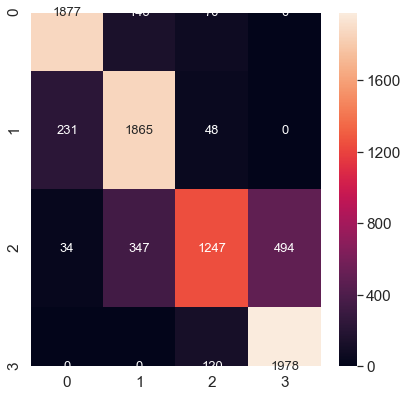

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.8798202034539863
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2090
           1       0.85      0.87      0.86      2144
           2       0.86      0.84      0.85      2122
           3       0.93      0.92      0.93      2098

    accuracy                           0.88      8454
   macro avg       0.88      0.88      0.88      8454
weighted avg       0.88      0.88      0.88      8454

Confusion matrix:


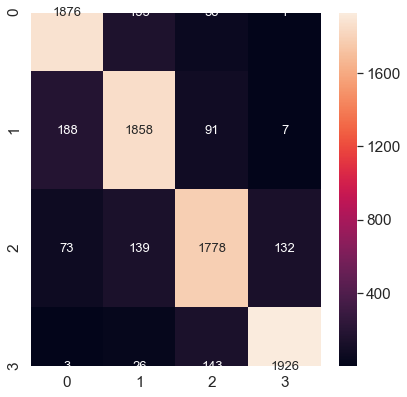

----------------------------------------------------------------

Accuracy of decision tree : 0.8769813106221906
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2090
           1       0.85      0.83      0.84      2144
           2       0.84      0.85      0.85      2122
           3       0.93      0.93      0.93      2098

    accuracy                           0.88      8454
   macro avg       0.88      0.88      0.88      8454
weighted avg       0.88      0.88      0.88      8454

Confusion matrix:


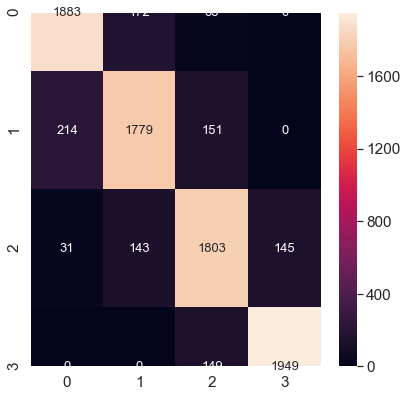

----------------------------------------------------------------

Accuracy of random forest : 0.9101017269931393
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2090
           1       0.89      0.88      0.89      2144
           2       0.89      0.88      0.89      2122
           3       0.95      0.94      0.95      2098

    accuracy                           0.91      8454
   macro avg       0.91      0.91      0.91      8454
weighted avg       0.91      0.91      0.91      8454

Confusion matrix:


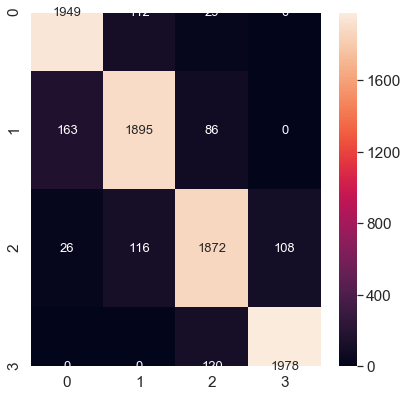

----------------------------------------------------------------

Feature importance:


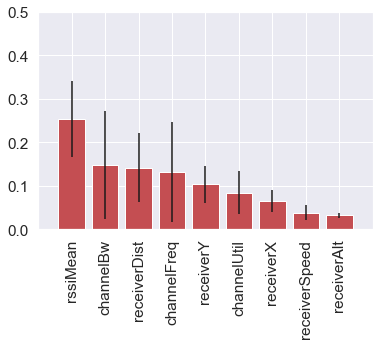

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.8727229713744973
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2090
           1       0.85      0.87      0.86      2144
           2       0.84      0.81      0.83      2122
           3       0.91      0.90      0.91      2098

    accuracy                           0.87      8454
   macro avg       0.87      0.87      0.87      8454
weighted avg       0.87      0.87      0.87      8454

Confusion matrix:


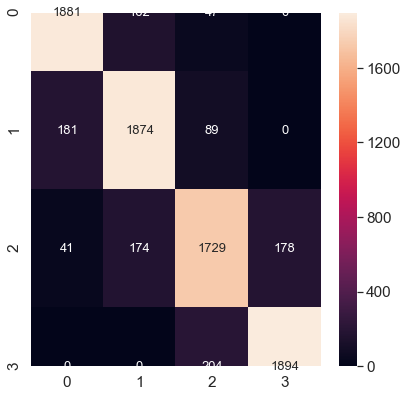

----------------------------------------------------------------



In [156]:
runClassifiersOuterOg(df = dataset, 
                      featuresToDrop=['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                                      'senderId', 'receiverId', \
                                      'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon'])

#### Classification without client location data
Doesn't require communication from client to AP.

Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(6.499, 52.316, closed='right')
 Interval(52.316, 72.02, closed='right')
 Interval(72.02, 303.115, closed='right')
 Interval(303.115, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.7714691270404542
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2090
           1       0.75      0.91      0.82      2144
           2       0.67      0.60      0.63      2122
           3       0.79      0.74      0.77      2098

    accuracy                           0.77      8454
   macro avg       0.77      0.77      0.77      8454
weighted avg       0.77      0.77      0.77      8454

Confusion matrix:


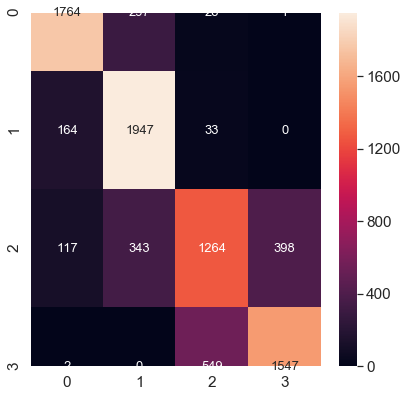

----------------------------------------------------------------

Accuracy of support vector machine : 0.7973740241305891
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      2090
           1       0.75      0.92      0.82      2144
           2       0.75      0.59      0.66      2122
           3       0.79      0.94      0.86      2098

    accuracy                           0.80      8454
   macro avg       0.80      0.80      0.79      8454
weighted avg       0.80      0.80      0.79      8454

Confusion matrix:


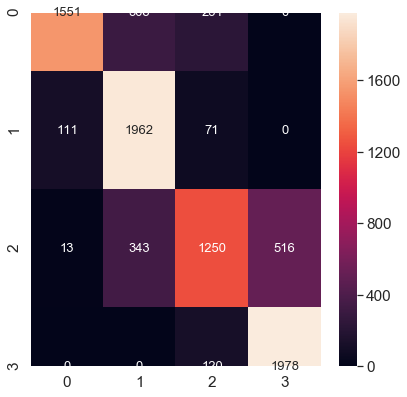

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.8634965696711616
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2090
           1       0.83      0.83      0.83      2144
           2       0.84      0.83      0.84      2122
           3       0.92      0.92      0.92      2098

    accuracy                           0.86      8454
   macro avg       0.86      0.86      0.86      8454
weighted avg       0.86      0.86      0.86      8454

Confusion matrix:


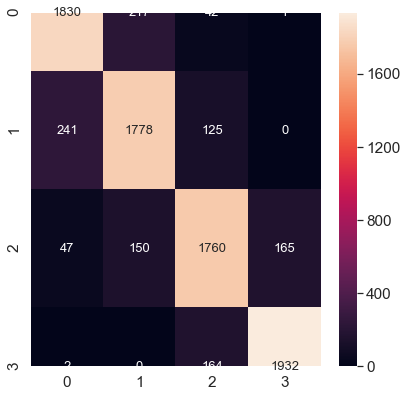

----------------------------------------------------------------

Accuracy of decision tree : 0.8404305654128224
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2090
           1       0.80      0.80      0.80      2144
           2       0.81      0.81      0.81      2122
           3       0.91      0.91      0.91      2098

    accuracy                           0.84      8454
   macro avg       0.84      0.84      0.84      8454
weighted avg       0.84      0.84      0.84      8454

Confusion matrix:


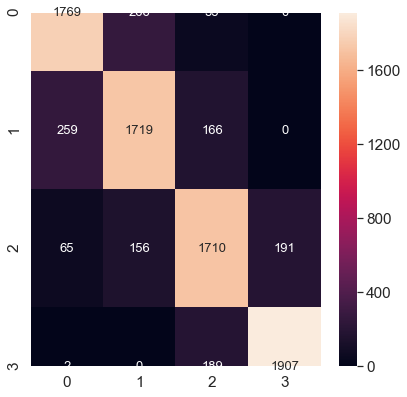

----------------------------------------------------------------

Accuracy of random forest : 0.8734326945824462
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2090
           1       0.84      0.85      0.84      2144
           2       0.86      0.84      0.85      2122
           3       0.92      0.93      0.93      2098

    accuracy                           0.87      8454
   macro avg       0.87      0.87      0.87      8454
weighted avg       0.87      0.87      0.87      8454

Confusion matrix:


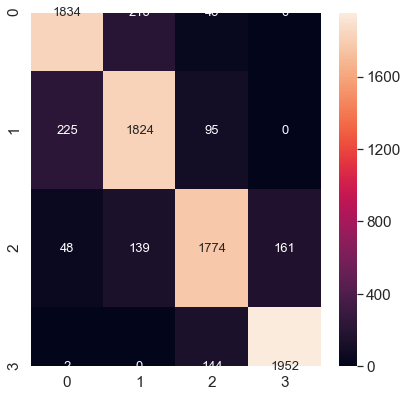

----------------------------------------------------------------

Feature importance:


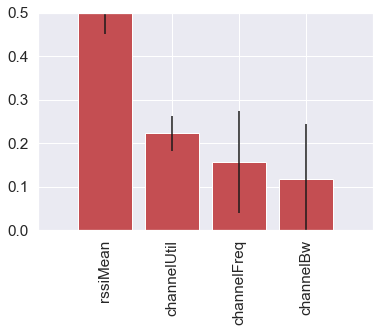

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.8450437662644902
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2090
           1       0.80      0.85      0.83      2144
           2       0.81      0.77      0.79      2122
           3       0.90      0.90      0.90      2098

    accuracy                           0.85      8454
   macro avg       0.85      0.85      0.85      8454
weighted avg       0.85      0.85      0.84      8454

Confusion matrix:


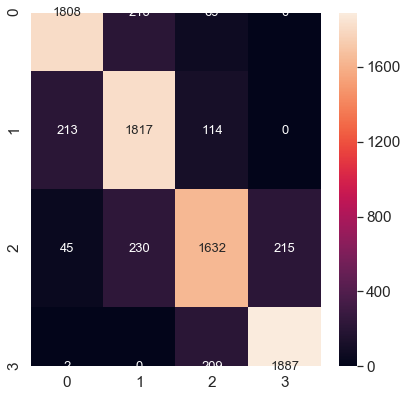

----------------------------------------------------------------



In [55]:
runClassifiersOuterOg(df=dataset, 
                      featuresToDrop=['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                                      'senderId', 'receiverId', 'receiverDist', \
                                      'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon', \
                                      'receiverId', 'receiverX', 'receiverY', \
                                      'receiverDist', 'receiverSpeed', 'receiverAlt'])

#### Results discussion
* Accuracy is "not great, not terrible".
* Random forest yielded the best accuracy (0.89 with location info, 0.82 without).

### Classification on principal components
#### Code

In [76]:
def getPcaDf(df, features, targetVar = 0.95):
  print(features)
  # separate features from target
  x = df.loc[:, features].values # x represents our features

  # standardization, see the following articles: 
  # 1. https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  # 2. https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2
  from sklearn.preprocessing import StandardScaler
  x = StandardScaler().fit_transform(x) # subtract mean and then scale to unit variance

  # run PCA
  from sklearn import decomposition
  pca = decomposition.PCA(targetVar) # maintain a targetVar portion of the variance
  pca.fit(x) 

  print("Found", pca.n_components_, "PCA components:", pca.explained_variance_)
  print("Explained variance ratios:", pca.explained_variance_ratio_, "total:", \
        sum(pca.explained_variance_ratio_))

  prinComps = pca.transform(x) # apply dimensionality reduction to x

  # create a data frame out of x
  pcaDf = pandas.DataFrame(data = prinComps)
  pcaDf['dataRateMean'] =  df['dataRateMean']
    
  return pcaDf

def runClassifiersOuterPc(df, featuresOfInterest):
  pcaDf = getPcaDf(df = df, features = featuresOfInterest)
  runClassifiersInner(df = pcaDf, targetName = "dataRateMean", scaler = None, nquantiles = 4)

#### Classification with client location info

['receiverAlt', 'receiverX', 'receiverY', 'receiverSpeed', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean']
Found 6 PCA components: [4.50529275 1.77148378 0.9293123  0.88031289 0.37002295 0.28720888]
Explained variance ratios: [0.50057032 0.19682455 0.10325326 0.09780907 0.0411122  0.03191097] total: 0.9714803617335606
Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(6.499, 52.316, closed='right')
 Interval(52.316, 72.02, closed='right')
 Interval(72.02, 303.115, closed='right')
 Interval(303.115, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.9286728176011355
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2090
           1       0.81      0.97      0.89      2144
           2       0.97      0.81      0.88      2122
           3       1.00      0.97      0.98      2098

    accuracy                          

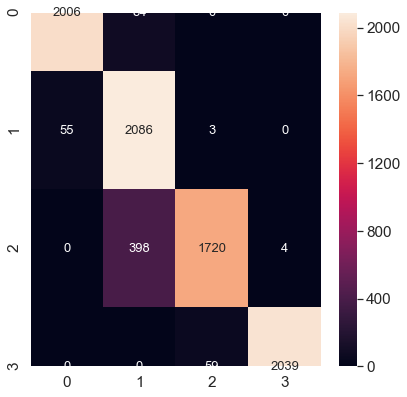

----------------------------------------------------------------

Accuracy of support vector machine : 0.9089188549798912
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2090
           1       0.81      0.91      0.86      2144
           2       0.96      0.82      0.88      2122
           3       0.99      0.96      0.98      2098

    accuracy                           0.91      8454
   macro avg       0.92      0.91      0.91      8454
weighted avg       0.91      0.91      0.91      8454

Confusion matrix:


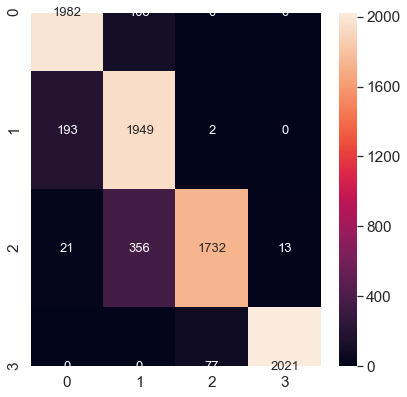

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.9086822805772415
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2090
           1       0.87      0.88      0.87      2144
           2       0.93      0.87      0.90      2122
           3       0.97      0.97      0.97      2098

    accuracy                           0.91      8454
   macro avg       0.91      0.91      0.91      8454
weighted avg       0.91      0.91      0.91      8454

Confusion matrix:


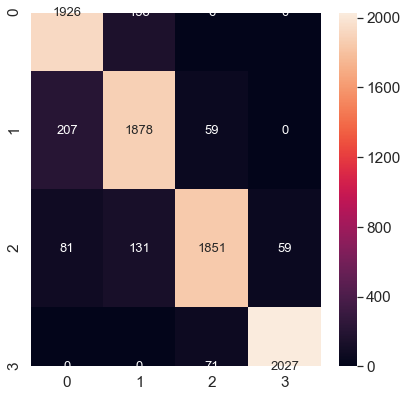

----------------------------------------------------------------

Accuracy of decision tree : 0.9040690797255737
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2090
           1       0.85      0.86      0.85      2144
           2       0.90      0.88      0.89      2122
           3       0.97      0.97      0.97      2098

    accuracy                           0.90      8454
   macro avg       0.90      0.90      0.90      8454
weighted avg       0.90      0.90      0.90      8454

Confusion matrix:


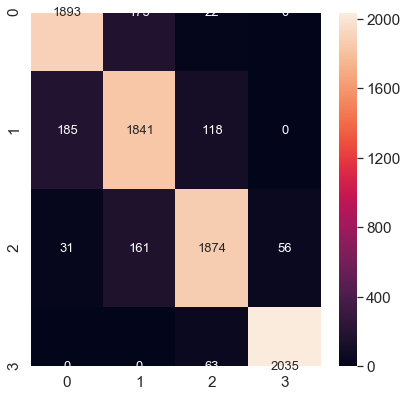

----------------------------------------------------------------

Accuracy of random forest : 0.9370712088951976
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2090
           1       0.90      0.90      0.90      2144
           2       0.95      0.93      0.94      2122
           3       0.99      0.97      0.98      2098

    accuracy                           0.94      8454
   macro avg       0.94      0.94      0.94      8454
weighted avg       0.94      0.94      0.94      8454

Confusion matrix:


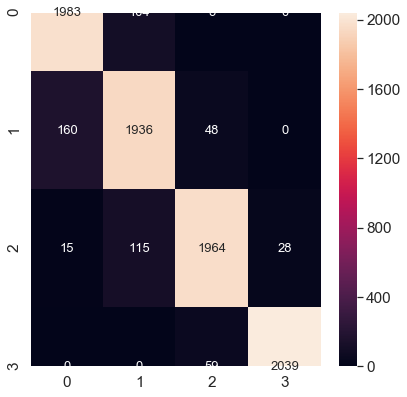

----------------------------------------------------------------

[0, 1, 2, 3, 4, 5]
Feature importance:


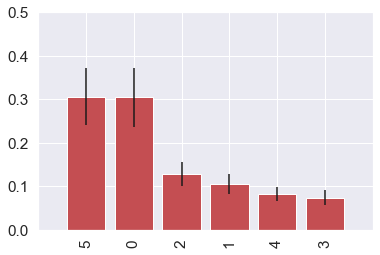

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.9810740477880293
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2090
           1       0.97      0.97      0.97      2144
           2       0.97      0.97      0.97      2122
           3       1.00      0.99      1.00      2098

    accuracy                           0.98      8454
   macro avg       0.98      0.98      0.98      8454
weighted avg       0.98      0.98      0.98      8454

Confusion matrix:


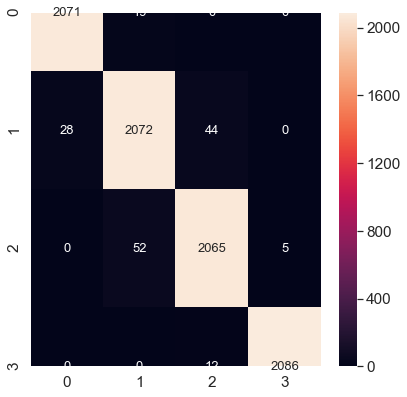

----------------------------------------------------------------



In [77]:
runClassifiersOuterPc(df = dataset, featuresOfInterest = ['receiverAlt', 'receiverX', 'receiverY', 'receiverSpeed', \
                                                          'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', \
                                                          'dataRateMean'])

#### Classification without client location info

['rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean']
Found 3 PCA components: [4.35760626 0.30863644 0.25252172]
Explained variance ratios: [0.87149032 0.0617251  0.05050255] total: 0.9837179728135897
Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(6.499, 52.316, closed='right')
 Interval(52.316, 72.02, closed='right')
 Interval(72.02, 303.115, closed='right')
 Interval(303.115, 2310.0, closed='right')]
----------------------------------------------------------------

Accuracy of logistic regression : 0.9278448071918618
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2090
           1       0.82      0.96      0.89      2144
           2       0.95      0.84      0.89      2122
           3       1.00      0.96      0.98      2098

    accuracy                           0.93      8454
   macro avg       0.93      0.93      0.93      8454
weighted avg       0.93      0.93      0.93      8454


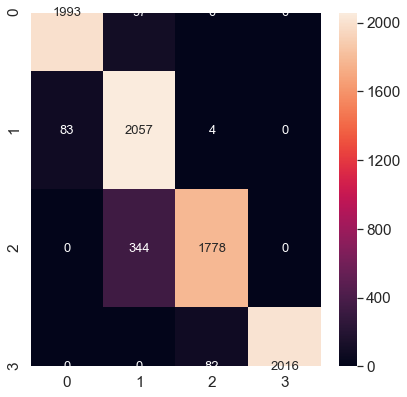

----------------------------------------------------------------

Accuracy of support vector machine : 0.9312751360302816
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2090
           1       0.84      0.96      0.89      2144
           2       0.94      0.84      0.89      2122
           3       1.00      0.95      0.98      2098

    accuracy                           0.93      8454
   macro avg       0.94      0.93      0.93      8454
weighted avg       0.94      0.93      0.93      8454

Confusion matrix:


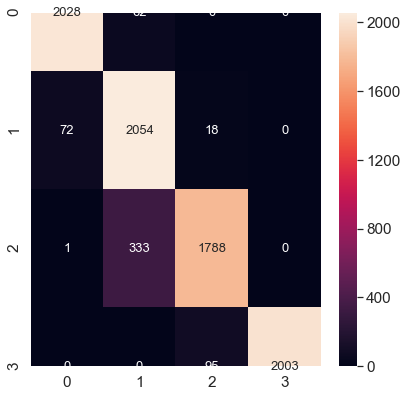

----------------------------------------------------------------

Accuracy of k-Nearest Neighbors : 0.9723207948899929
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2090
           1       0.94      0.97      0.96      2144
           2       0.97      0.94      0.96      2122
           3       0.99      0.99      0.99      2098

    accuracy                           0.97      8454
   macro avg       0.97      0.97      0.97      8454
weighted avg       0.97      0.97      0.97      8454

Confusion matrix:


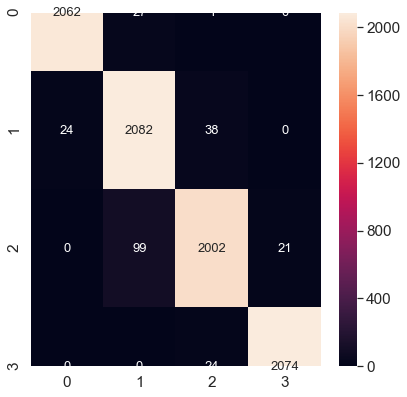

----------------------------------------------------------------

Accuracy of decision tree : 0.9535131298793471
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2090
           1       0.93      0.92      0.92      2144
           2       0.94      0.94      0.94      2122
           3       0.98      0.99      0.99      2098

    accuracy                           0.95      8454
   macro avg       0.95      0.95      0.95      8454
weighted avg       0.95      0.95      0.95      8454

Confusion matrix:


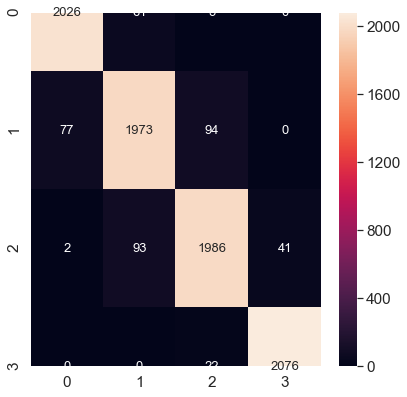

----------------------------------------------------------------

Accuracy of random forest : 0.9674710196356754
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2090
           1       0.94      0.96      0.95      2144
           2       0.97      0.94      0.95      2122
           3       0.99      0.99      0.99      2098

    accuracy                           0.97      8454
   macro avg       0.97      0.97      0.97      8454
weighted avg       0.97      0.97      0.97      8454

Confusion matrix:


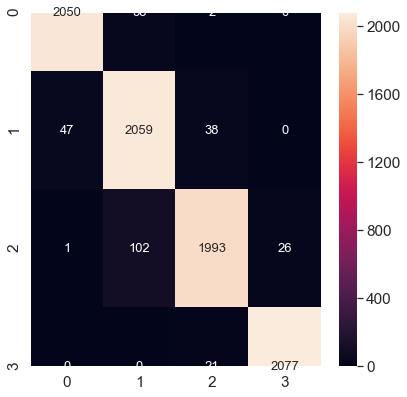

----------------------------------------------------------------

[0, 1, 2]
Feature importance:


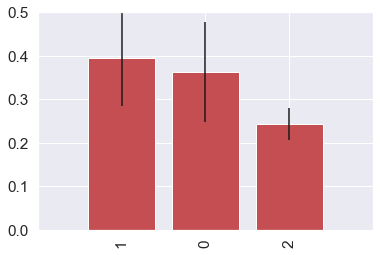

Accuracy of neural network - Multi-Layer Perceptron (MLP) : 0.9988171279867518
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2090
           1       1.00      1.00      1.00      2144
           2       1.00      1.00      1.00      2122
           3       1.00      1.00      1.00      2098

    accuracy                           1.00      8454
   macro avg       1.00      1.00      1.00      8454
weighted avg       1.00      1.00      1.00      8454

Confusion matrix:


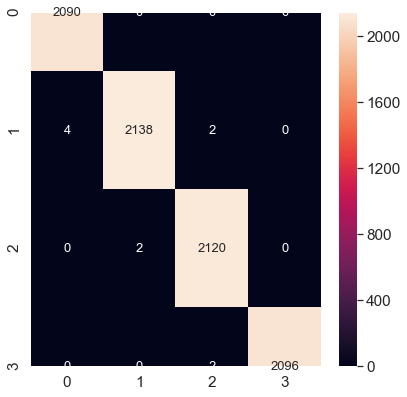

----------------------------------------------------------------



In [78]:
runClassifiersOuterPc(df = dataset, featuresOfInterest = ['rssiMean', 'channelFreq', 'channelBw', 'channelUtil', \
                                                          'dataRateMean'])

#### Results discussion
* For the w/ location info case, kNN was best with an accuracy of 0.87. For the wo/ location info case, SVM was best with 0.79 accuracy.

* PCA didn't actually improve accuracy. Focusing on the w/ location info case, we went from a best of 0.89 with random forest to 0.87 with kNN. Not sure why?

## Data rate prediction as a regression problem
Predict data rate as a continuous variable.
### Code

In [238]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

def rmse(yTrue, yPred):
  """
    Compute root mean square error.
  """
  return numpy.sqrt(numpy.mean(numpy.square(yTrue - yPred)))

def testRegUnderClass(regName, yTrain, yTest, yPred, nquantiles=4):
  """
    See how well regression does under the classification task.
  """
  ySeries = pandas.concat([yTrain, yTest])
  _, bins = pandas.qcut(ySeries, q = nquantiles, labels = False, retbins = True) # actually discretize stuff
  bins[0] = -1.0 # ensure zeros fit in 1st interval
  yTestCat = pandas.cut(yTest, bins = bins, labels = False)
  yPredCat = pandas.cut(yPred, bins = bins, labels = False)
  print(bins)
    
  # FIXME : remove 'out of bounds' values from both yTestCat and yPredCat
  yTestCat = yTestCat.values
  ixs = np.argwhere(~np.isnan(yPredCat)).reshape(-1)
  print(ixs)
  print(yTestCat[ixs])
  print(yPredCat[ixs])
  evalClfPerf(regName, yTestCat[ixs], yPredCat[ixs])

def runRegression(reg, regName, xTrain, yTrain, xTest, yTest, printSep=True):
  """
    Run single regression, passed in as argument reg.
  """

  print(regName)
  reg.fit(xTrain, yTrain)
  yPred = reg.predict(xTest) # predict on the unseen data
  yPred = yPred.clip(min = 0.0) # because we know data rate can't be negative, make negative values zero

  print("Root-Mean-Square Error: %.2f" % rmse(yTest, yPred))
  print('Variance score: %.2f' % r2_score(yTest, yPred)) # 1 is perfect prediction
  
  testRegUnderClass(regName, yTrain, yTest, yPred)

  if printSep: printSeparator()
    
  return yPred

def runRegressionsInner(df, targetName, scaler=None):
  """
    Run multiple regressions for the data frame passed in as argument df.
  """

  #  split dataset into training and test
  x = df.drop(targetName, axis=1) # x contains all the features
  y = df[targetName] # y contains only the label

  # scaling, see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  if scaler:
    x = scaler.fit_transform(x)

  # xTrain contains features for training, xTest contains features for testing
  # test_size = 0.3 means 30% data for testing
  # random_state = 1, is the seed value used by the random number generator
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 1)    
    
  # some info about the data
  print("Train y data information - min:", numpy.min(yTrain), ", max:", numpy.max(yTrain), ', mean:', \
        numpy.mean(yTrain), ", standard deviation:", numpy.std(yTrain))
  print("Test y data information - min:", numpy.min(yTest), ", max:", numpy.max(yTest), ', mean:', \
        numpy.mean(yTest), ", standard deviation:", numpy.std(yTest))
  printSeparator()
    
  # train and test models

  # linear regression
  regLinr = LinearRegression()
  yPredLinr = runRegression(regLinr, "Linear regression", xTrain, yTrain, xTest, yTest, printSep=False)
#  print('Linear regression coefs: \n', regLinr.coef_)  
  printSeparator()

  # svr
  regSvr = svm.SVR(gamma='scale')
  yPredSvr = runRegression(regSvr, "Support Vector Regression (SVR)", xTrain, yTrain, xTest, yTest)

  # neural network (Multi Layer Perceptron w/ backpropagation)
  regMlp = MLPRegressor(solver='lbfgs', random_state=1, max_iter=1000)
  yPredMlp = runRegression(regMlp, "Neural network - Multi-Layer Perceptron (MLP)", xTrain, yTrain, xTest, yTest)
    
  y = numpy.array([yTrain, yTest, yPredLinr, yPredSvr, yPredMlp]) 

  # plot violins for the different y distributions
  vioInPairs = (('Train', yTrain.values), ('Test', yTest.values), ('Linear regression', yPredLinr), \
                ('Support vector regression', yPredSvr), ('Multi-layer perceptron', yPredMlp))
  vioDf = pandas.DataFrame(columns=['Dataset','Mean data rate (Mbit/s)'])
  crow = 0
  for x, yarray in vioInPairs:
    for y in yarray:
      vioDf.loc[crow] = [x, y]
      crow += 1
        
  plt.figure(figsize=(14,8)) # new figure
  sns.set(style="whitegrid")
  sns.violinplot(x='Dataset', y='Mean data rate (Mbit/s)', data=vioDf)
  plt.show()

### Classification on original features
#### Code

In [187]:
def runRegressionsOuterOg(df, featuresToDrop): 
  regDf = df.copy() # work on copy to preserve original

  # we don't care for some columns no more
  regDf.drop(featuresToDrop, axis=1, inplace=True)
  
  #  split dataset into training and test
  x = regDf.drop("dataRateMean", axis = 1) # x contains all the features
  y = regDf["dataRateMean"] # y contains only the label

  from sklearn.preprocessing import MinMaxScaler
  mms = MinMaxScaler() # subtract minimum and divide by range
  runRegressionsInner(df = regDf, targetName = "dataRateMean", scaler=mms)

#### Classification with client location info

Train y data information - min: 6.5 , max: 2310.0 , mean: 218.6693534438145 , standard deviation: 310.0974262625639
Test y data information - min: 6.5 , max: 2310.0 , mean: 215.16180634634992 , standard deviation: 306.03407081295734
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 157.19
Variance score: 0.74
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 2]
Accuracy of Linear regression : 0.5969955050863497
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      2090
           1       0.76      0.16      0.27      2144
           2       0.41      0.83      0.55      2122
           3       0.78      0.57      0.66      2098

    accuracy                           0.60      8454
   macro avg       0.69      0.60      0.57      8454
weighted avg       0.69      0.60      0.57      8454

Confusion matrix:


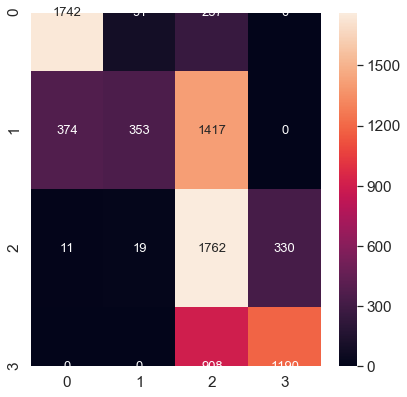

----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 195.61
Variance score: 0.59
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[1 2 0 ... 2 0 1]
Accuracy of Support Vector Regression (SVR) : 0.48261178140525196
              precision    recall  f1-score   support

           0       0.92      0.52      0.66      2090
           1       0.35      0.20      0.25      2144
           2       0.35      0.90      0.51      2122
           3       0.99      0.32      0.48      2098

    accuracy                           0.48      8454
   macro avg       0.65      0.48      0.48      8454
weighted avg       0.65      0.48      0.47      8454

Confusion matrix:


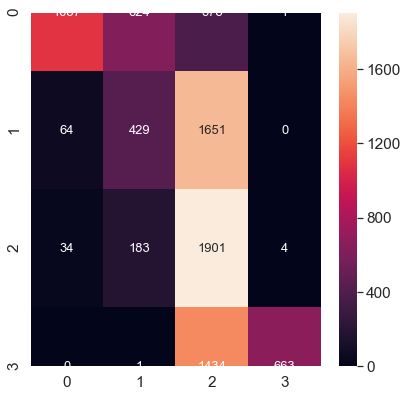

----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 121.38
Variance score: 0.84
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 2]
Accuracy of Neural network - Multi-Layer Perceptron (MLP) : 0.7057014431038562
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      2090
           1       0.66      0.58      0.62      2144
           2       0.57      0.62      0.60      2122
           3       0.80      0.93      0.86      2098

    accuracy                           0.71      8454
   macro avg       0.71      0.71      0.70      8454
weighted avg       0.71      0.71      0.70      8454

Confusion matrix:


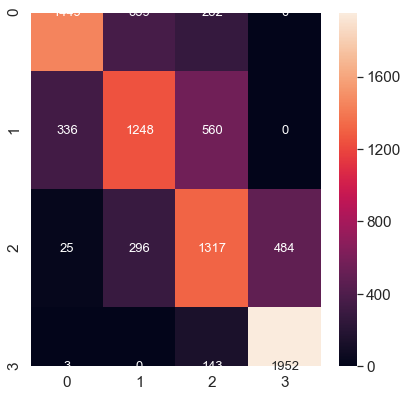

----------------------------------------------------------------



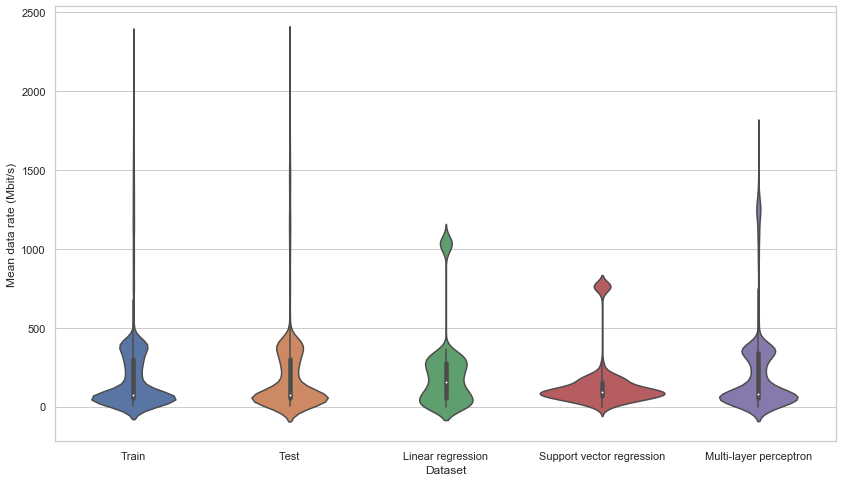

In [237]:
featuresToDrop = ['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                  'senderId', 'receiverId', \
                  'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon']

runRegressionsOuterOg(df = dataset, featuresToDrop = featuresToDrop)

#### Classification without client location info

Train y data information - min: 6.5 , max: 2310.0 , mean: 218.6693534438145 , standard deviation: 310.0974262625639
Test y data information - min: 6.5 , max: 2310.0 , mean: 215.16180634634992 , standard deviation: 306.03407081295734
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 157.21
Variance score: 0.74
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 2]
Accuracy of Linear regression : 0.5972320794889993
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2090
           1       0.80      0.16      0.27      2144
           2       0.40      0.83      0.54      2122
           3       0.78      0.56      0.65      2098

    accuracy                           0.60      8454
   macro avg       0.70      0.60      0.58      8454
weighted avg       0.70      0.60      0.57  

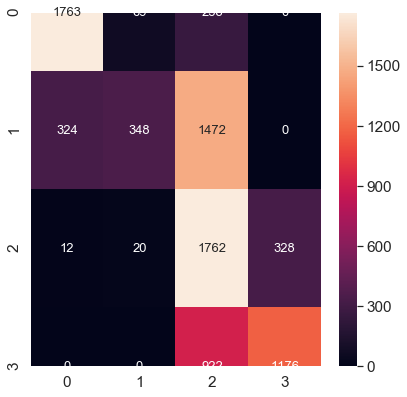

----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 195.27
Variance score: 0.59
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 1]
Accuracy of Support Vector Regression (SVR) : 0.5387982020345399
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      2090
           1       0.47      0.34      0.39      2144
           2       0.38      0.86      0.53      2122
           3       0.99      0.32      0.48      2098

    accuracy                           0.54      8454
   macro avg       0.69      0.54      0.54      8454
weighted avg       0.69      0.54      0.54      8454

Confusion matrix:


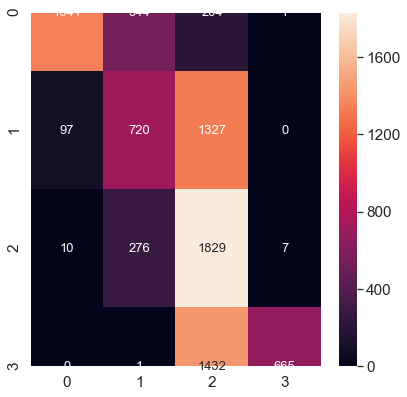

----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 129.37
Variance score: 0.82
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 2]
Accuracy of Neural network - Multi-Layer Perceptron (MLP) : 0.7607049917198959
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2090
           1       0.82      0.54      0.65      2144
           2       0.64      0.69      0.66      2122
           3       0.79      0.95      0.86      2098

    accuracy                           0.76      8454
   macro avg       0.77      0.76      0.75      8454
weighted avg       0.77      0.76      0.75      8454

Confusion matrix:


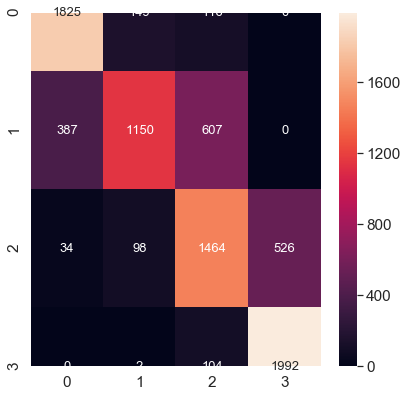

----------------------------------------------------------------



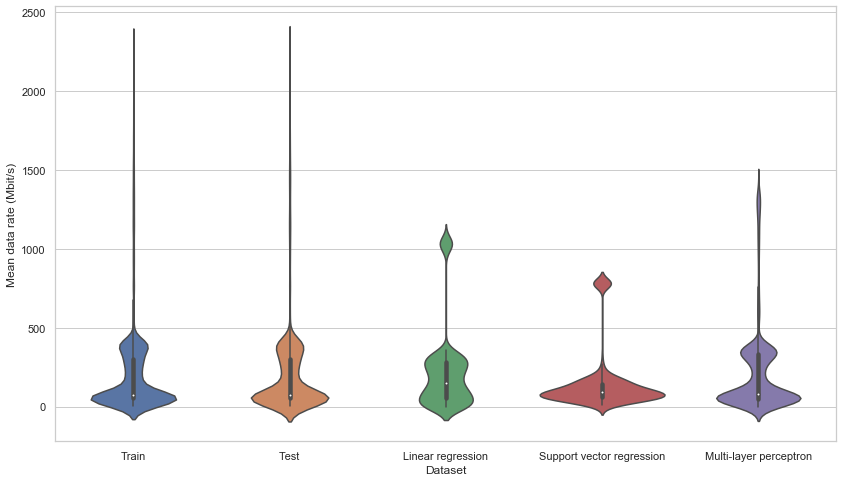

In [239]:
runRegressionsOuterOg(df = dataset, \
                      featuresToDrop = ['systime', 'traceNr', 'nrClients', 'isInLap', 'isIperfOn', \
                                      'senderId', 'receiverId', 'receiverDist', \
                                      'nBytesReceived', 'wifiType', 'dataRateMedian', 'tghptConsumer', 'lat', 'lon', \
                                      'receiverId', 'receiverX', 'receiverY', \
                                      'receiverDist', 'receiverSpeed', 'receiverAlt'])

#### Results discussion
* MLP neural network significantly outperformed the other methods in terms of RMSE.
* MLP meural network was significantly slower than other methods (a few seconds vs instantenous).
* The lack of client location info noticeably impacts performance. RMSE shot up from 19.08 vs 26.50 for MLP.

### Classification on principal components
I.e. perform PCA first.
#### Code

In [242]:
def runRegressionsOuterPc(df, featuresOfInterest):
  pcaDf = getPcaDf(df = df, features = featuresOfInterest, targetVar = 0.99) # 99% variance works better here
  runRegressionsInner(df = pcaDf, targetName = "dataRateMean", scaler = None)

#### Classification with client location info

['receiverAlt', 'receiverX', 'receiverY', 'receiverSpeed', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean']
Found 7 PCA components: [4.50529275 1.77148378 0.9293123  0.88031289 0.37002295 0.28720888
 0.18107082]
Explained variance ratios: [0.50057032 0.19682455 0.10325326 0.09780907 0.0411122  0.03191097
 0.02011827] total: 0.9915986273108526
Train y data information - min: 6.5 , max: 2310.0 , mean: 218.6693534438145 , standard deviation: 310.0974262625639
Test y data information - min: 6.5 , max: 2310.0 , mean: 215.16180634634992 , standard deviation: 306.03407081295734
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 2.40
Variance score: 1.00
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 2]
Accuracy of Linear regression : 0.9801277501774308
              precision    recall  f1-score   support

     

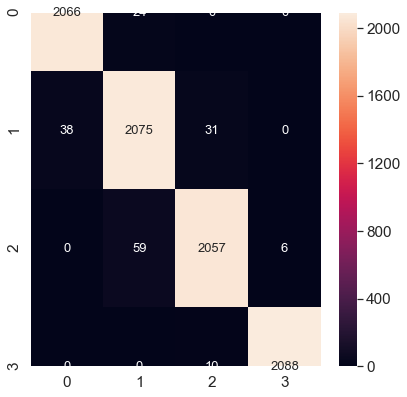

----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 136.08
Variance score: 0.80
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 1]
Accuracy of Support Vector Regression (SVR) : 0.8399574166075231
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      2090
           1       0.75      0.71      0.73      2144
           2       0.73      0.94      0.82      2122
           3       0.98      0.95      0.97      2098

    accuracy                           0.84      8454
   macro avg       0.86      0.84      0.84      8454
weighted avg       0.85      0.84      0.84      8454

Confusion matrix:


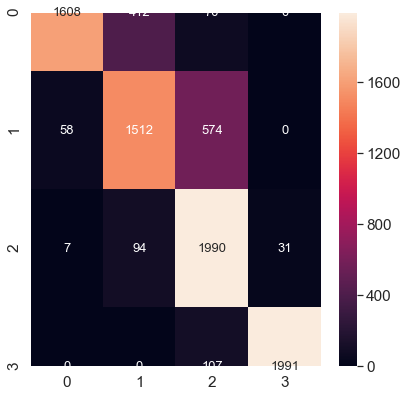

----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 0.38
Variance score: 1.00
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0. 2. 0. ... 2. 0. 1.]
Accuracy of Neural network - Multi-Layer Perceptron (MLP) : 0.9931320307874482
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2090
           1       0.98      0.99      0.99      2144
           2       0.99      0.98      0.99      2122
           3       1.00      1.00      1.00      2089

    accuracy                           0.99      8445
   macro avg       0.99      0.99      0.99      8445
weighted avg       0.99      0.99      0.99      8445

Confusion matrix:


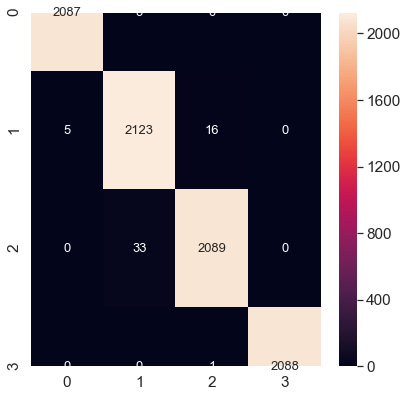

----------------------------------------------------------------



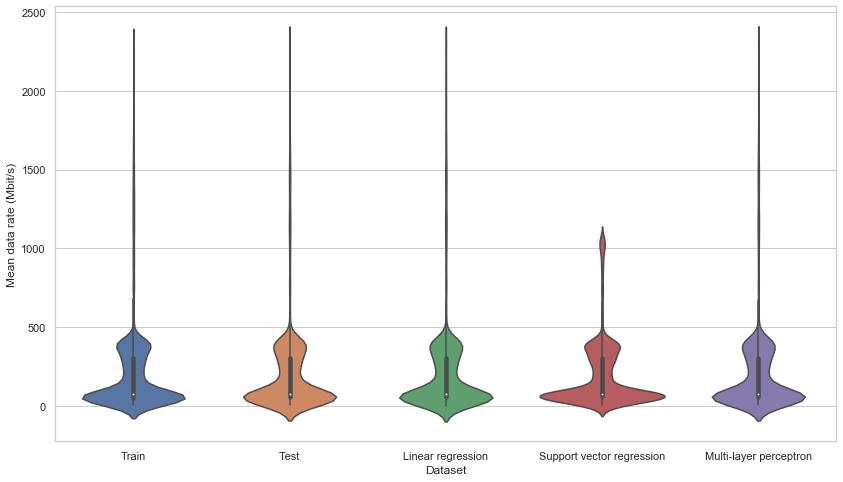

In [240]:
featuresOfInterest = ['receiverAlt', 'receiverX', 'receiverY', 'receiverSpeed', \
                      'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', \
                      'dataRateMean']
runRegressionsOuterPc(df = dataset, featuresOfInterest = featuresOfInterest)

#### Classification without client location info

['rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean']
Found 4 PCA components: [4.35760626 0.30863644 0.25252172 0.07980608]
Explained variance ratios: [0.87149032 0.0617251  0.05050255 0.01596065] total: 0.9996786233182235
Train y data information - min: 6.5 , max: 2310.0 , mean: 218.6693534438145 , standard deviation: 310.0974262625639
Test y data information - min: 6.5 , max: 2310.0 , mean: 215.16180634634992 , standard deviation: 306.03407081295734
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 0.52
Variance score: 1.00
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 1]
Accuracy of Linear regression : 0.9848592382304234
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2090
           1       0.96      0.99      0.97      2144
           2       1.00

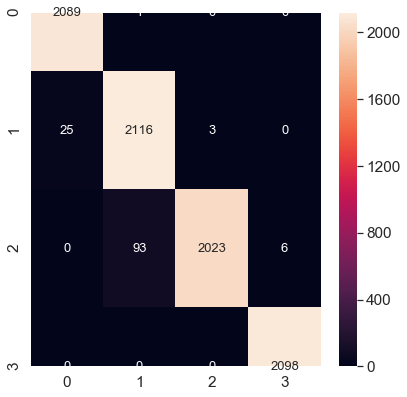

----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 120.97
Variance score: 0.84
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 2]
Accuracy of Support Vector Regression (SVR) : 0.9321031464395553
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2090
           1       0.93      0.83      0.88      2144
           2       0.84      0.95      0.89      2122
           3       0.98      1.00      0.99      2098

    accuracy                           0.93      8454
   macro avg       0.94      0.93      0.93      8454
weighted avg       0.94      0.93      0.93      8454

Confusion matrix:


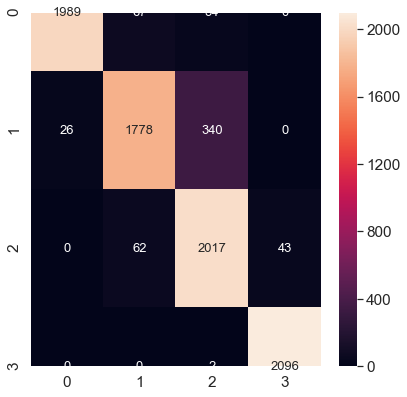

----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 0.01
Variance score: 1.00
[-1.00000000e+00  5.23157468e+01  7.20196806e+01  3.03114747e+02
  2.31000000e+03]
[   0    1    2 ... 8451 8452 8453]
[0 2 0 ... 2 0 1]
[0 2 0 ... 2 0 1]
Accuracy of Neural network - Multi-Layer Perceptron (MLP) : 0.9995268511947007
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2090
           1       1.00      1.00      1.00      2144
           2       1.00      1.00      1.00      2122
           3       1.00      1.00      1.00      2098

    accuracy                           1.00      8454
   macro avg       1.00      1.00      1.00      8454
weighted avg       1.00      1.00      1.00      8454

Confusion matrix:


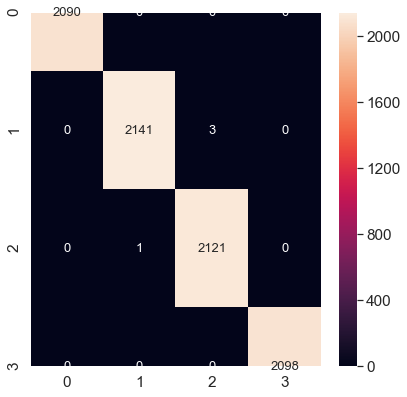

----------------------------------------------------------------



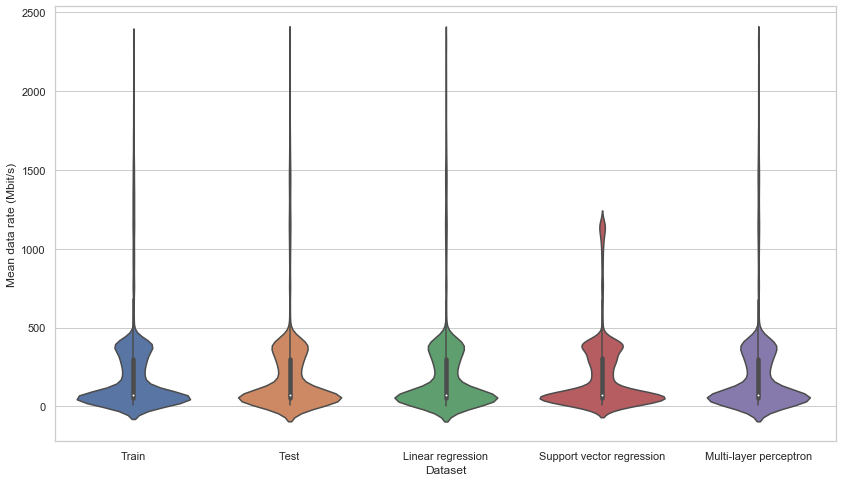

In [241]:
featuresOfInterest = ['rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMean']
runRegressionsOuterPc(df = dataset, featuresOfInterest = featuresOfInterest)

### Results discussion
* MLP neural network performed the best across the board.
* MLP was the slowest method.
* Doing PCA improved MLP performance for the w/ location info case (RMSE from 19.08 to 17.67), but reduced it in the wo/ location info case (RMSE from 26.50 to 28.1). 
* Lacking location info negatively impacts performance. In the non-PCA, MLP configuration, RMSE jumped to 26.5 from 19.08.

## Conclusions and future work
* For classification, kNN and random forest are the top performers.
* For regression, the MLP neural network performed the best.
* Having client location negatively affects predictability, in a significant manner.
* Neural network may be too slow to run on an AP?
* In the future we'll want to have experiments that give us data about the impact of channel utilization on throughput. Throughput should be a function of data rate and channel utilization.